<a href="https://colab.research.google.com/github/DavidCalebChaparroOrozco/Pneumonia_Detection/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data from the Kaggle website
---
## Los datos  desde la pagina de Kaggle

In [1]:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
!unzip -q 'archive.zip'

--2021-09-23 21:03:39--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2021-09-23 21:03:39--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce33589e5b60204d059c35d314e.dl.dropboxusercontent.com/cd/0/inline/BWuHBOf8ZebwVS5X2hLMKe7_pHnnjIPFeKm2dgdD88_1PXMuJrHwgYO59iuGFyjck64ZkkqLheDH_P8vUJUxMUMccrRsPkcuovlHsbz6q7p7vC__CbPJuHB1GKeACfLgtknzYiRvUeX2CUL71vjxAFiD/file# [following]
--2021-09-23 21:03:39--  https://uce33589e5b60204d059c35d314e.dl.dropboxusercontent.com/cd/0/inline/BWuHBOf8ZebwVS5X2hLMKe7_pHnnjIPFeKm2dgdD88_1PXMuJrHwgYO59iuGFyjck64ZkkqLheDH_P8vUJUxMUMccrRsP

## The libraries I have used and their respective seeds
---
## Las librerias que he usado y con su respectiva semilla


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(2)

## Separating files with Pathlib
---
## Separación de las ficheros con Pathlib


In [3]:
train_path = Path('chest_xray/train/')
validation_path = Path('chest_xray/test')
test_path = Path('chest_xray/val')

## Take all paths within the folders 'normal' and 'pneumonia'.
---
## Tomar todas las rutas dentro de las carpetas 'normal' y 'pneumonia'


In [4]:
train_image_paths = train_path.glob('*/*')
val_image_paths = validation_path.glob('*/*')
print(train_image_paths)

<generator object Path.glob at 0x7fc6cc4abd50>


## Convert generator object to List of elements 
---
## Generar un objeto a una lista de elementos

In [5]:
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)
print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1278-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0418-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0482-0001.jpeg')]


## Convert X position to Strings
---
## Convertir la posición X en Strings

In [6]:
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 
print(train_image_paths[:3])

['chest_xray/train/NORMAL/NORMAL2-IM-1278-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0418-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0482-0001.jpeg']


##  Amount of data from training and validation datasets
---
## Cantidad de datos de los datasets de entrenamiento y validación

In [7]:
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

# Data wrangling
---
## Cirugia de Datos

In [8]:
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[0, 0, 0]


## Function to transform images and create an object in TF
--- 
## Función para transformar las imágenes y crear un objeto en TF



In [9]:
size = 32
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(size)

    return dataset


## Creation of a training and verification dataset.
---
## Creación de un dataset de entrenamiento y verificación.


In [10]:
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 534 ms, sys: 372 ms, total: 906 ms
Wall time: 6.15 s
(32, 224, 224, 3)
(32,)


## Samples of training images
---
## Muestras de imagenes de entrenamiento


PNEUMONIA


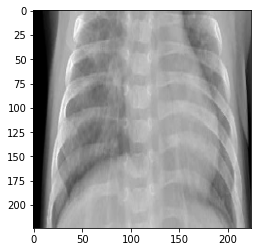

In [11]:
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [12]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 25.2 ms, sys: 2.02 ms, total: 27.3 ms
Wall time: 31.8 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


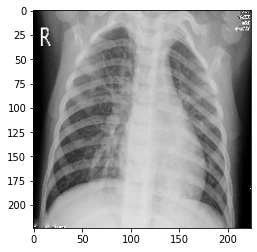

In [13]:
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [14]:
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


## Compilation of the model with the optimizer, missing data and its metrics
---
## Compilación del modelo con el optimizador, los datos perdidos y sus métricas

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

## Model training
---
## Entrenamiento del modelo

In [18]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//size,
    epochs=10,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//size,
)

Epoch 1/10
163/163 [==============================] - 170s 919ms/step - loss: 0.1322 - accuracy: 0.9511 - precision: 0.9628 - recall: 0.9636 - val_loss: 1.0568 - val_accuracy: 0.6332 - val_precision: 0.9632 - val_recall: 0.4586

Epoch 00001: val_loss improved from 318.38858 to 1.05680, saving model to best_weights.h5
Epoch 2/10
163/163 [==============================] - 151s 926ms/step - loss: 0.0627 - accuracy: 0.9757 - precision: 0.9831 - recall: 0.9838 - val_loss: 49.7953 - val_accuracy: 0.3618 - val_precision: 1.0000 - val_recall: 0.0051

Epoch 00002: val_loss did not improve from 1.05680
Epoch 3/10
163/163 [==============================] - 151s 925ms/step - loss: 0.0522 - accuracy: 0.9816 - precision: 0.9876 - recall: 0.9876 - val_loss: 0.3753 - val_accuracy: 0.8503 - val_precision: 0.9427 - val_recall: 0.8022

Epoch 00003: val_loss improved from 1.05680 to 0.37526, saving model to best_weights.h5
Epoch 4/10
163/163 [==============================] - 151s 927ms/step - loss: 0.052

## Interpretation of metrics
---
## Interpretación de las métricas

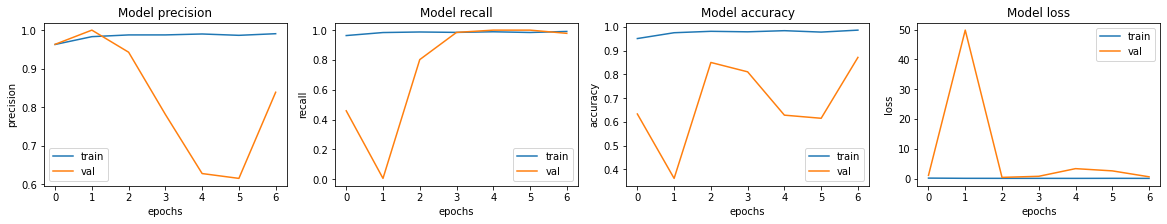

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Save the best model
---
## Guardar el mejor modelo

In [20]:
model.load_weights("best_weights.h5")
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Complete model
---
## Modelo completo

In [21]:
loaded_model = tf.keras.models.load_model("model.h5")

## Create a 'test' dataset
---
## Crear un dataset de 'prueba'

In [22]:
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(size)
)

## Samples of validation images
---
## Muestras de imagenes de validación

In [23]:
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


NORMAL


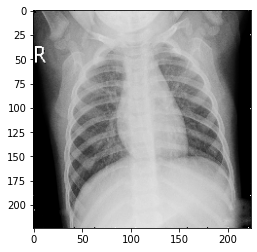

In [24]:
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

## Model evaluation
---
## Evaluación del modelo

In [25]:
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 2s 2s/step - loss: 0.7588 - accuracy: 0.6250 - precision: 1.0000 - recall: 0.2500
 Testing Acc :  0.625
 Testing Precision  1.0
 Testing Recall  0.25
